# How popular is the President?
> "Experimenting with a Gaussian Process to model presidential popularity across time"

- toc: true
- badges: true
- comments: true
- author: Alexandre Andorra
- categories: [popularity, Macron, Gaussian processes, polls]
- image: images/gp-popularity.png

I like working on time series, because they usually relate to something concrete. I've also long been intrigued by [Gaussian Processes](https://en.wikipedia.org/wiki/Gaussian_process) -- they have a mathematical beauty and versatility that I've always found intriguing, if only because you can parametrize the model in ways where you can interpret it.

But... they are hard to fit -- the number of gradient computation scales with the cube of the number of data points. And in the Bayesian framework, we're trying to estimate the _whole_ distribution of outcomes, not only _one_ single point, which adds to the challenge.

One thing I learned so far in my open-source programming journey is not to be afraid of what you're afraid of -- to what you'll legitimately answer: "wait, what??". Let me rephrase: if a method scares you, the best way to understand it is to work on an example where you need it. This will dissipate (part of) the magic behind it and help you cross a threshold in your understanding.

So that's what I did with Gaussian Processes! That all came from a simple question: how does the popularity of French presidents evolve within term and across terms? I often hear people frenetically commenting the latest popularity poll (frequently the same people who later will complain that "polls are always wrong", but that's another story), and in these cases I'm always worried that we're reacting to noise -- maybe it's just natural that a president experiences a dip in popularity at the middle of his term?

To answer this question, I compiled all the popularity opinion polls of French presidents since the term limits switched to 5 years (in 2002). Let's see what the data look like, before diving into the Gaussian Process model.

## Show me the data!

Here are the packages we'll need:

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import xarray as xr
from scipy.special import expit as logistic

In [2]:
# hide
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

Now, let's load up the data in a dataframe called `d`. You'll notice that, in addition to the polling data, the dataframe also contains the quarterly unemployment rate in France (downloaded from the [French statistical office](https://www.insee.fr/fr/statistiques/serie/001688526#Telechargement)). As this variable is usually well correlated with politicians' and parties' popularity, we will use it as a predictor in our model.

As I'll explain below, we're computing the popularity every month, but since unemployment data are released quarterly, we just forward-fill the unemployment values when they are missing -- which is, I insist, an assumption, and as such it should be tested and played with, to check its impact on the model's inferences (there is a Binder and Google Collab link at the top of the page, so feel free to do so!). I could also use more intricate techniques to forecast unemployment, but that would be an overkill for our purpose here.

In [3]:
# hide
PARTIES = {
    "chirac2": "right",
    "sarkozy": "right",
    "hollande": "left",
    "macron": "center",
}

# collapse-show
all_presidents = pd.read_csv(
    "https://raw.githubusercontent.com/AlexAndorra/pollsposition_models/master/data/raw_popularity_presidents.csv",
    header=0,
    index_col=0,
    parse_dates=True,
)

# restrict data to after the switch to 5-year term
d = all_presidents.loc[all_presidents.index >= pd.to_datetime("2002-05-05")]

# convert to proportions
d[["approve_pr", "disapprove_pr"]] = d[["approve_pr", "disapprove_pr"]].copy() / 100
d = d.rename(columns={"approve_pr": "p_approve", "disapprove_pr": "p_disapprove"})

# raw monthly average to get fixed time intervals
# TODO: replace by poll aggregation
d = d.groupby("president").resample("M").mean().reset_index(level=0).sort_index()

d["party"] = d.president.replace(PARTIES)

ELECTION_FLAGS = (
    (d.index.year == 2002) & (d.index.month == 5)
    | (d.index.year == 2007) & (d.index.month == 5)
    | (d.index.year == 2012) & (d.index.month == 5)
    | (d.index.year == 2017) & (d.index.month == 5)
)
d["election_flag"] = 0
d.loc[ELECTION_FLAGS, "election_flag"] = 1

# convert to nbr of successes
d["N_approve"] = d.samplesize * d["p_approve"]
d["N_disapprove"] = d.samplesize * d["p_disapprove"]
d[["N_approve", "N_disapprove"]] = d[["N_approve", "N_disapprove"]].round().astype(int)

# compute total trials
d["N_total"] = d.N_approve + d.N_disapprove

/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [4]:
# hide
unemp = pd.read_csv(
    "https://raw.githubusercontent.com/AlexAndorra/pollsposition_models/master/data/predictors/chomage_national_trim.csv",
    sep=";",
    skiprows=2,
).iloc[:, [0, 1]]
unemp.columns = ["date", "unemployment"]
unemp = unemp.sort_values("date")

# as timestamps variables:
unemp.index = pd.period_range(start=unemp.date.iloc[0], periods=len(unemp), freq="Q")
unemp = unemp.drop("date", axis=1)

d = d.reset_index()

# add quarters to main dataframe:
d.index = pd.DatetimeIndex(d["index"].values).to_period("Q")
d.index.name = "quarter"

# merge with unemployment:
d = d.join(unemp).reset_index().set_index("index")
d.index.name = "month"
d["unemployment"] = d.unemployment.fillna(method="ffill")

In [5]:
# hide_input
d.to_csv("../../pollsposition_models/popularity/plot_data/complete_popularity_data.csv")
d

quarter president   samplesize  p_approve  p_disapprove   party  \
month                                                                        
2002-05-31  2002Q2   chirac2   964.250000   0.502500      0.442500   right   
2002-06-30  2002Q2   chirac2   970.000000   0.505000      0.425000   right   
2002-07-31  2002Q3   chirac2   947.333333   0.533333      0.406667   right   
2002-08-31  2002Q3   chirac2  1028.000000   0.520000      0.416667   right   
2002-09-30  2002Q3   chirac2  1017.500000   0.525000      0.420000   right   
...            ...       ...          ...        ...           ...     ...   
2020-09-30  2020Q3    macron  1008.428571   0.350000      0.611429  center   
2020-10-31  2020Q4    macron   994.000000   0.401667      0.568333  center   
2020-11-30  2020Q4    macron  1093.333333   0.400000      0.574444  center   
2020-12-31  2020Q4    macron  1000.600000   0.390000      0.588000  center   
2021-01-31  2021Q1    macron  1023.250000   0.380000      0.592500  center   

            election_flag  N_approve  N_disapprove  N_total  unemployment  
month                                                                      
2002-05-31              1        485           427      912           7.5  
2002-06-30              0        490           412      902           7.5  
2002-07-31              0        505           385      890           7.5  
2002-08-31              0        535           428      963           7.5  
2002-09-30              0        534           427      961           7.5  
...                   ...        ...           ...      ...           ...  
2020-09-30              0        353           617      970           8.8  
2020-10-31              0        399           565      964           8.8  
2020-11-30              0        437           628     1065           8.8  
2020-12-31              0        390           588      978           8.8  
2021-01-31              0        389           606      995           8.8  

[225 rows x 11 columns]

If you go check the raw underlying notebook, you'll see that there is a bunch of data cleaning involved to get to that format. The most important is that we perform a simple monthly average to get fixed time intervals, which makes computation easier for the GP -- and it's actually not that far-fetched to consider that we get to "observe" the president's popularity only once a month, thanks to the average of all polls taken in this month.

Ideally though, we wouldn't do that, as 1) it breaks the purely generative aspect of the model (now the model doesn't take as observations the raw polls but their average), and 2) it tricks the model into believing that the dispersion in polls is lower than it actually is.

As a first implementation though, let's make our lives easier and see how that goes -- we can always go back to the model and relax this assumption if needed.

Speaking of making our lives easier, let's write a helper function to convert datetimes to numbers, in reference to a given date. This will be useful to use time as a predictor in our model -- more precisely, as an input to our GP (completely lost? Don't worry, we'll get back to that).

In [7]:
def dates_to_idx(timelist):
    """Convert datetimes to numbers in reference to a given date"""

    reference_time = timelist[0]
    t = (timelist - reference_time) / np.timedelta64(1, "M")

    return np.asarray(t)


time = dates_to_idx(d.index)
time[:10]

array([0.        , 0.98564652, 2.00414793, 3.02264934, 4.00829586,
       5.02679726, 6.01244379, 7.03094519, 8.0494466 , 8.96938335])

Let's also define a function to standardize data (mean 0 and standard deviation 1), which we'll use for our only continuous predictor, the unemployment rate. Indeed that will make it easier to set our priors for the coefficient associated to unemployment, and our sampler will have a better time sampling -- so, you know two 🐦 with one 💎 !

In [8]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

## Build me a model

Now is time to define the model, which should make things clearer. The polls are, quite simply, realizations of a Binomial distribution: for each poll, a number $n$ of people are surveyed, and $y$ of them say they approve of the president's job. Note that we ignore those who report no opinion, because their numbers are usually negligeable, so $n - y$ represents the number of people who disapprove of the president's job. Statistically speaking, we have $y \sim Binomial(n, p)$, where $p$ equals the proportion of people supporting the president.

$p$ is really what we're after here: given the observed polls, what is our inference of the true, latent support of the president in the population? But I can feel that something is bothering you, isn't it (yeah, I can read minds)? Right now you're thinking: "but aren't polls _noisy_ observations of reality"? To what I'll answer: "boy, you're really good at this!". Polls are indeed noisy estimates and a variety of factors account for these polling errors.

So, we need to take that into account, and a quick way to do that is to use the [Beta-Binomial distribution](https://en.wikipedia.org/wiki/Beta-binomial_distribution), which handles overdispersed data -- i.e observations that are more variable than a classic Binomial distribution would expect and can accomodate. If you want more details about these models (poetically named "continuous mixture models"), I'd refer you to chapter 12 of [Richard McElreath's excellent _Statistical Rethinking_](https://nbviewer.jupyter.org/github/pymc-devs/resources/blob/master/Rethinking_2/Chp_12.ipynb).

In the Beta-Binomial distribution, the Binomial probabilities are no longer fixed, but are rather random variables drawn from a common Beta distribution. So, in addition to the number of trials, $n$, Beta-Binomial distributions are parametrized by two strictly positive reals, $\alpha$ and $\beta$, which control the Beta distribution.

The thing is that $\alpha$ and $\beta$ usually don't have a real meaning, so it's often easier to parametrize the Beta distribution with two other parameters,
$p$ and $\theta$, which roughly correspond to the mean and precision respectively: for a given $p$, a higher $\theta$ means that we are more skeptical of very weak or very strong probabilities -- those near 0 or 1.

We don't need a prior on $p$, as it will be a deterministic function of our regression. But we do need one for $\theta$. A value of 2 translates in a uniform prior over probabilities, which is not what we want -- we _know_ presidential approval never goes below 10% and above 90% (at least in France). To get that, we can set $\theta = 10$. You can play around with the code below to get a sense of how the Beta family behaves:

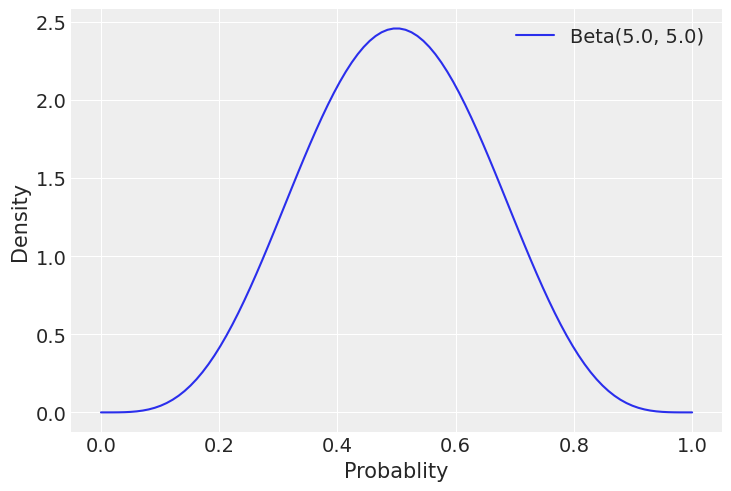

In [8]:
x_plot = np.linspace(0, 1, 100)
pbar = 0.5
theta = 10.0

plt.plot(
    x_plot,
    np.exp(pm.Beta.dist(pbar * theta, (1 - pbar) * theta).logp(x_plot).eval()),
    label=f"Beta({pbar * theta}, {(1 - pbar) * theta})",
)
plt.xlabel("Probablity")
plt.ylabel("Density")
plt.legend();

Looks good right? And you can see that the mathematical link between $(p, \theta)$ and $(\alpha, \beta)$ is quite simple:

$$ \alpha = p \times \theta $$
$$ \beta = (1 - p) \times \theta $$

So, we want to assume that the precision is at least 10. To that end, we can use a trick and define $\theta = \tilde{\theta} + 10$, where $\tilde{\theta} \sim Exponential(1)$, which works because exponential distributions have a minimum of zero.

Let's turn our attention to $p$ now, the parameter we really care about. We model it through the addition of a linear component ($baseline + \beta_{honeymoon} \times election\_ flag + \beta_{unemp} \times unemp\_ data$ and a non-parametric component (the GP, $f\_time$). The GP basically allows us to tell the model that time and popularity covary, but we don't know the exact functional form of this romantic relationship, so we'd like the model to figure it out for us -- yep, GPs are pretty cool; I bet they were popular in college! To make sure $p$ stays between 0 and 1 (it's a probability, remember?), we use the [logistic link function](https://en.wikipedia.org/wiki/Logistic_function).

We now have all the parts to build our model! We just need to define the priors for all our unknown parameters. That what we'll do in the next section, but first, let's assemble all the building blocks, to contemplate our beautiful inference machine (yeah, I took a couple poetry classes in highschool):

$$y \sim BetaBinomial(\alpha=p \times \theta, \: \beta=(1 - p) \times \theta, \: n)$$

$$theta \sim Exponential(1) + 10$$

$$p = logistic(baseline + f\_ time + \beta_{honeymoon} \times election\_ flag + \beta_{unemp} \times log(unemp\_ data))$$

$$baseline \sim Normal(-0.7, 0.5)$$

$$\beta_{honeymoon} \sim Normal(-0.5, 0.3)$$

$$\beta_{unemp} \sim Normal(0, 0.2)$$

$$f\_ time \sim GP(0, \Sigma)$$

$$\Sigma = amplitude^2 \times Matern52(length\_ scale)$$

$$amplitude \sim HalfNormal(1)$$

$$length\_ scale \sim Gamma(\alpha=5, \beta=2)$$

As I know you're very attentive, you have noticed that we use the _logarithm_ of unemployment, not the raw unemployment rate. It's because we think that what matters for citizens when they think about unemployment is its _order of magnitude_, not its absolute values.

Other than that, the model should look pretty familiar to you now -- well, except for the priors on the GP and the coefficients. So, let's turn to that right now!

## Time to choose... your GP prior

Priors are very important to fit GPs properly, so let's spend some time thinking about our priors for a more refined model of the popularity of the president. Note that this is a tutorial about how to code up a GP in PyMC3, not a tutorial about the theory of GPs, so we assume familiarity with the concepts. If you need a refresher about the theory, take a look at PyMC3's Mauna Loa [notebook](https://docs.pymc.io/notebooks/GP-MaunaLoa.html), Michael Betancourt's excellent [case study](https://betanalpha.github.io/assets/case_studies/gaussian_processes.html) and chapter 21 of [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/BDA3.pdf).

### Kernel relations

We will use a fairly common Matern 5/2 kernel. It has the advantage of being less smooth than the classic exponentiated quadratic kernel, which is useful here as the GP must be able to jump from one regime to another very quickly when a new president is sworn in (you'll see that the swing in popularity is usually very wide).

We could probably do something better here by signaling these change points to our GP (after all, we _know_ when a new president comes in, so we should tell it to our model). That way, we could use different kernels for each president. Or we could look into non-stationary kernels: the Matern kernel is stationary, meaning that the estimated covariance between data points doesn't vary depending on the period we're in -- maybe French people's assessment of their presidents varied less (i.e was more autocorrelated) in the 2000s, when there were no 24/7 TV news networks?

In short, it's easy to imagine that the way popularity varies with time (which is what our GP tries to capture) itself varies according to the president's personality and the times he lived in. The improvements above would integrate this assumption into the model. But, again, this is a first version -- let's see if, like the [2019 Nobel Chemistry prize](https://www.nobelprize.org/prizes/chemistry/2019/goodenough/facts/), it's good enough.

### Amplitude -- Don't go so high!

The Matern 5/2 kernel is parametrized with an amplitude and a length scale. The amplitude controls, quite surprisingly, the amplitude of the GP realized values: the bigger the amplitude, the larger the variations in the GP values. You can think of it as the $y$ axis in the plots you will see below -- the range of values that $f(x)$ can take on, $f$ being drawn from the GP.

Proportions in polls vary from 0 to 1, and the GP models only part of the variation in polls. We will also standardize our predictor (unemployment data), which means it will have a standard deviation of 1. So, in this context, $Halfnormal(1)$ should be a weakly regularizing prior.

### Length scale -- Don't go so far!

I know you're quite impatient, so I already hear you asking: "what about the length scale now?". Well, ok! But do you even know what that controls? The length scale can be interpreted as the degree of correlation between the GP values: the higher it is, the smoother the functions drawn from the GP, because their realized values will be highly correlated. In a way, you can think of the length scale as the maximum distance on the $x$ axis at which two points in time still share information.

In our case, we can imagine that polls taken 3 months ago still have a bit of influence on today's results, but it's probably not the case for polls from more than 6 months ago. So we need a prior that's both avoiding 0 (by definition, it never makes sense for the length scale to be _exactly_ 0) and constraining values above about 6 months. The Gamma family of distributions is usually a helpful choice here, as it is very versatile and has support over the positive real line. Here are a few examples, to give you an idea:

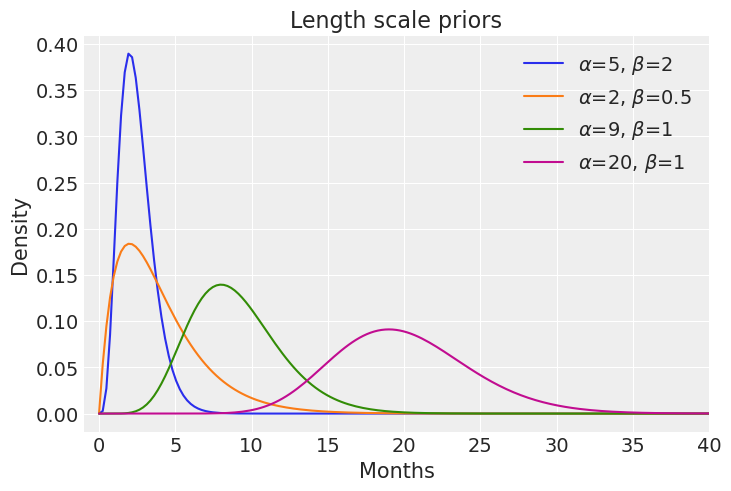

In [9]:
# collapse
x = np.linspace(0, 120, 500)
priors = [
    (r"$\alpha$=5, $\beta$=2", pm.Gamma.dist(alpha=5, beta=2)),
    (r"$\alpha$=2, $\beta$=0.5", pm.Gamma.dist(alpha=2, beta=0.5)),
    (r"$\alpha$=9, $\beta$=1", pm.Gamma.dist(alpha=9, beta=1)),
    (r"$\alpha$=20, $\beta$=1", pm.Gamma.dist(alpha=20, beta=1)),
]

fig = plt.figure()

for i, prior in enumerate(priors):
    plt.plot(x, np.exp(prior[1].logp(x).eval()), label=prior[0])

plt.xlim((-1, 40))
plt.xlabel("Months")
plt.ylabel("Density")
plt.title("Length scale priors")
plt.legend();

The blue line, representing $Gamma(5, 2)$ has our favors, because most of the probability mass is between 0 and 6 months, which we deemed reasonable above.

If you're a bit lost, that's quite normal: GPs are rather meta, so it takes some time to develop intuition about them. A nice thing though is that we can relate the GP's parameters to the reality of our use-case, which makes it more interpretable.

In any case, take your time going through this, and understanding will come. This notebook about [mean and covariance functions](https://docs.pymc.io/notebooks/GP-MeansAndCovs.html) and this [case study](https://betanalpha.github.io/assets/case_studies/probability_densities.html) are good educational ressources to think about priors in the context of GPs.

### Putting the GP together -- You're beautiful!

The best we can do now to make this more concrete is to draw some functions from our GP, prior to seeing any data. That will help us understand our model and determine if our prior choices make sense. This is pretty simple to do with PyMC3:

In [10]:
amplitude_trend = pm.HalfNormal.dist(1.0).random(1)
ls_trend = pm.Gamma.dist(alpha=5, beta=2).random(1)
cov_trend = amplitude_trend ** 2 * pm.gp.cov.Matern52(1, ls_trend)

prior_timepoints = np.linspace(0, 60, 200)[:, None]
K = cov_trend(prior_timepoints).eval()

gp_prior_samples = pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=20_000)

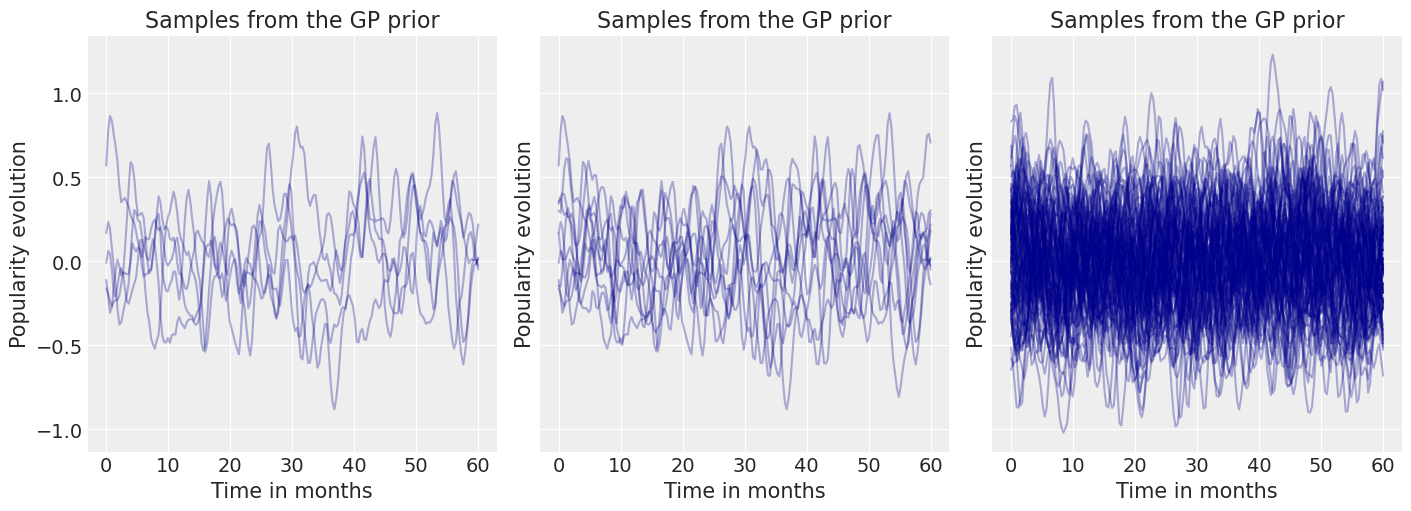

In [11]:
# hide_inputs
_, (left, mid, right) = plt.subplots(
    1, 3, figsize=(14, 5), constrained_layout=True, sharex=True, sharey=True
)
for ax, samples in zip((left, mid, right), (5, 10, 100)):
    ax.plot(
        prior_timepoints,
        gp_prior_samples[:samples].T,
        color="darkblue",
        alpha=0.3,
    )
    ax.set_title("Samples from the GP prior")
    ax.set_xlabel("Time in months")
    ax.set_ylabel("Popularity evolution");

Each line is a realization of the GP prior. We indeed see the effect of our priors on both the amplitude and length scale, with most functions fluctuating between -1 and 1 (amplitude) and the auto-correlation being limited to around 6 months (length scale).

As we didn't specify a mean for our GP, PyMC by default centers it at 0, which happens to also be what we want: the GP is here to capture the _residual_ variation of popularity once we've taken into effect the baseline, unemployment and honeymoon effects.

The "spaghetti" plots above are useful to get an idea of individual functions and the correlations between their values, but it's hard to understand exactly where different quantiles end up. To get that information, "ribbon" plots are more interesting. Let's compute and display the median, 40-60%, 30-70%, 20-80% and 10-90% quantile intervals of the GP prior samples we already drew above:

/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interp

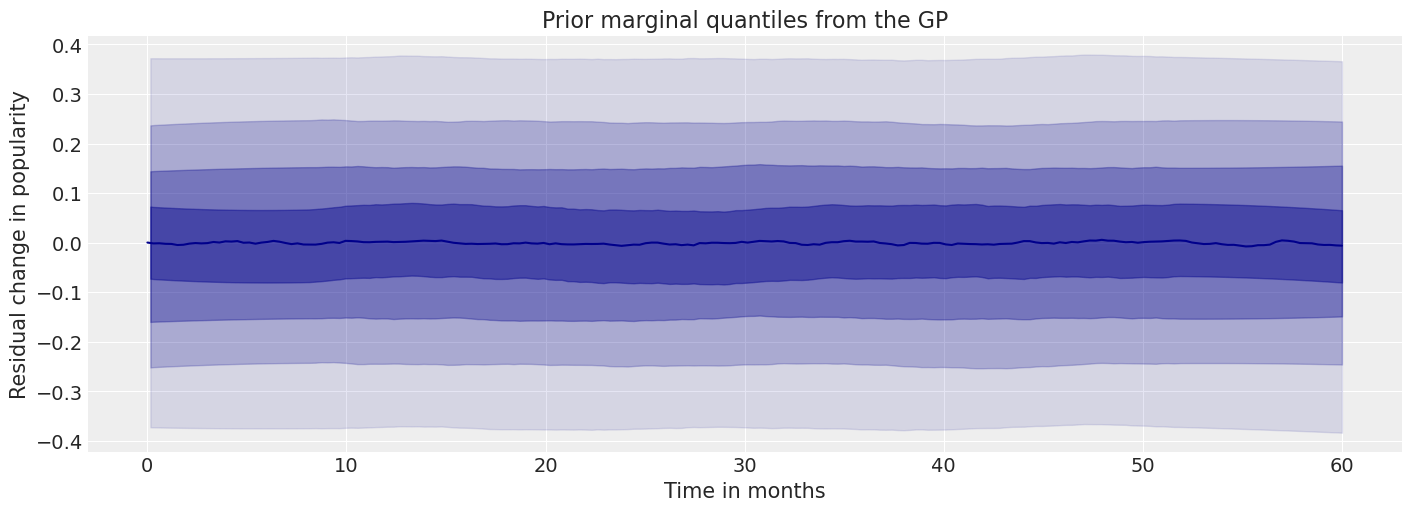

In [12]:
# hide_input
_, ax = plt.subplots(1, 1, figsize=(14, 5))

ax.plot(
    prior_timepoints.flatten(), np.median(gp_prior_samples, axis=0), color="darkblue"
)
az.plot_hdi(
    prior_timepoints.flatten(),
    gp_prior_samples,
    hdi_prob=0.2,
    ax=ax,
    color="darkblue",
    fill_kwargs={"alpha": 0.4},
)
az.plot_hdi(
    prior_timepoints.flatten(),
    gp_prior_samples,
    hdi_prob=0.4,
    ax=ax,
    color="darkblue",
    fill_kwargs={"alpha": 0.3},
)
az.plot_hdi(
    prior_timepoints.flatten(),
    gp_prior_samples,
    hdi_prob=0.6,
    ax=ax,
    color="darkblue",
    fill_kwargs={"alpha": 0.2},
)
az.plot_hdi(
    prior_timepoints.flatten(),
    gp_prior_samples,
    hdi_prob=0.8,
    ax=ax,
    color="darkblue",
    fill_kwargs={"alpha": 0.1},
)

ax.set_title("Prior marginal quantiles from the GP")
ax.set_xlabel("Time in months")
ax.set_ylabel("Residual change in popularity");

Easier to visualize the different expectations, right? Let's note though that these plots ignore the correlation between time points, so they underestimate the overall variation in the GP samples -- and indeed you can see that the $y$ axis is on a smaller scale than the spaghetti plots'.

## But wait, there is more... priors to choose

Enjoying it so far? Of course you are! Well good news: we still have priors to pick for the intercept, honeymoon and unemployment effects 🍾

Our regression intercept is also the mean function of our GP -- the value it reverts to when data start lacking. There, we have quite a lot of information: 50% popularity is historically high for a French president, so keeping the mean at zero is sub-optimal -- our parameter lives on the logit scale, so a prior centered at 0 means a prior centered at $logistic(0) = 0.5$ on the outcome space.

We can do better: based on our domain knowledge, we expect most presidents to have a baseline popularity between 20% and 50% -- in other words, French people rarely love their presidents but often _really_ dislike them. $Normal(-0.7, 0.5)$ looks reasonable in that regard: it expects 95% of the probability mass to be between -1.7 and 0.3, i.e $logistic(-1.7) = 15\%$ and $logistic(0.3) = 57\%$, with a mean approval of $logistic(-0.7) = 33\%$:

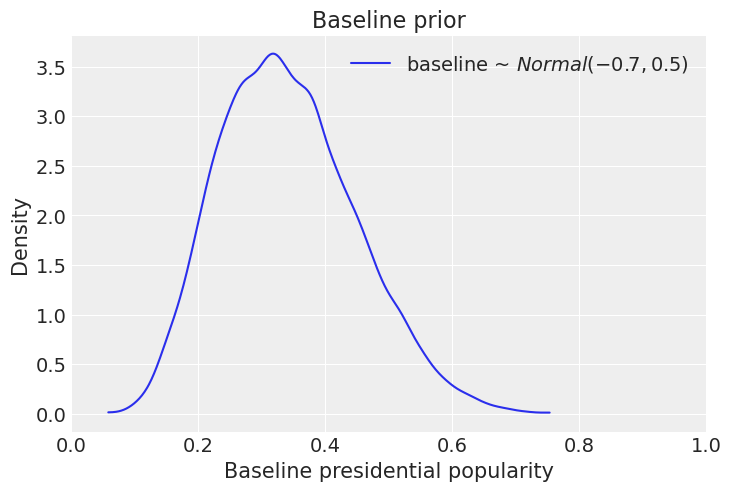

In [13]:
# hide_input
baseline_prior_samples = pm.Normal.dist(-0.7, 0.5).random(size=20_000)

ax = az.plot_kde(
    logistic(baseline_prior_samples),
    label="baseline ~ $Normal(-0.7, 0.5)$",
)
ax.set_xlim((0, 1))
ax.set_xlabel("Baseline presidential popularity")
ax.set_ylabel("Density")
ax.set_title("Baseline prior");

Similarly, we have a lot of domain knowledge about the honeymoon effect -- the bump in popularity that a newly elected president gets when taking office. Here again, we have a lot of domain knowledge: we should not be surprised by big bumps, since it's not uncommon to see the outgoing president around 20-30% popularity and the new one around 60%. So, an effect centered around 40% and allowing for lower and larger effects seems appropriate:

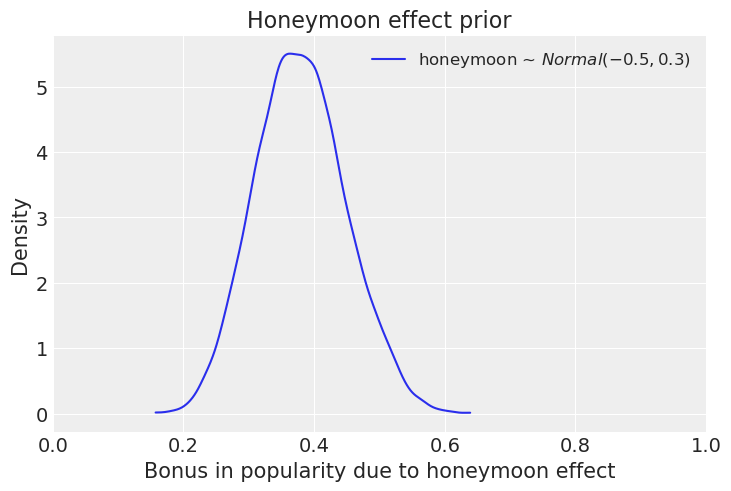

In [14]:
# hide_input
honeymoon_prior_samples = pm.Normal.dist(-0.5, 0.3).random(size=20_000)

ax = az.plot_kde(
    logistic(honeymoon_prior_samples),
    label="honeymoon ~ $Normal(-0.5, 0.3)$",
)
ax.set_xlim((0, 1))
ax.set_xlabel("Bonus in popularity due to honeymoon effect")
ax.set_ylabel("Density")
ax.set_title("Honeymoon effect prior")
ax.legend(fontsize=12);

For the unemployment effect though, we should expect a much milder effect. First, because socio-demographic variables usually have small effects in the litterature. Second, because unemployment is not the only thing influencing voters' opinion of the president: there is also, notably, partisanship, which makes movements in popularity less responsive to unemployment -- if you really don't like the president, you probably need to see a very low unemployment rate before starting to credit him. Finally, people probably don't know the exact current value of unemployment! They just have a fuzzy memory of where it stands -- also potentially influenced by their partisanship.

The beauty of the Bayesian framework is that we can integrate that uncertainty easily in our model: just consider the unemployment rate as a random variable! So, in practice, we put a probability distribution on the unemployment data:

$$u\_uncert = log(unemp\_ data) + u\_diff$$
$$u\_diff \sim Normal(0, 0.1)$$

Concretely, that means that unemployment is the result of the data we observe, plus some random noise around it, which conveys the uncertainty in people's mind. Why $\sigma = 0.1$ for $u\_diff$, you ask? Well, data are standardized, so 0.1 is equivalent to 10% of the data's standard deviation. Since we're using a Normal distribution, this prior means that 95% of the time, we expect the "true" unemployment rate (the one that people have in mind when thinking about it) is equal to the observed rate $\pm \, 0.2$, which seems reasonable when the observations are standardized.

All in all, we expect the unemployment to have a small negative effect, but we're not sure. So, let's center our prior on $0$ (i.e no expected effect) and use a weakly regularizing $\sigma$ (in log-odds space): $\beta_{unemp} \sim Normal(0, 0.2)$. To see the effect of this prior, we have to plug it into the formula for our model, $popularity = logistic(baseline + f\_ time + \beta_{unemp} \times u\_uncert$ (we don't care about the honeymoon effect here, because the GP is already very flexible when it's not constrained by data, so you won't see a difference anyway).

We just have to generate fake unemployment data. Again, as we standardized the real data, simulating data between -3 and 3 is largely sufficient to cover the whole range of possible data:

In [15]:
unemp_effect_prior_samples = pm.Normal.dist(0.0, 0.2).random(size=20_000)
fake_unemp = np.linspace(-3, 3, 200)[None, :]

prior_approval = logistic(
    baseline_prior_samples[:, None]
    + gp_prior_samples
    + unemp_effect_prior_samples[:, None] * fake_unemp
)

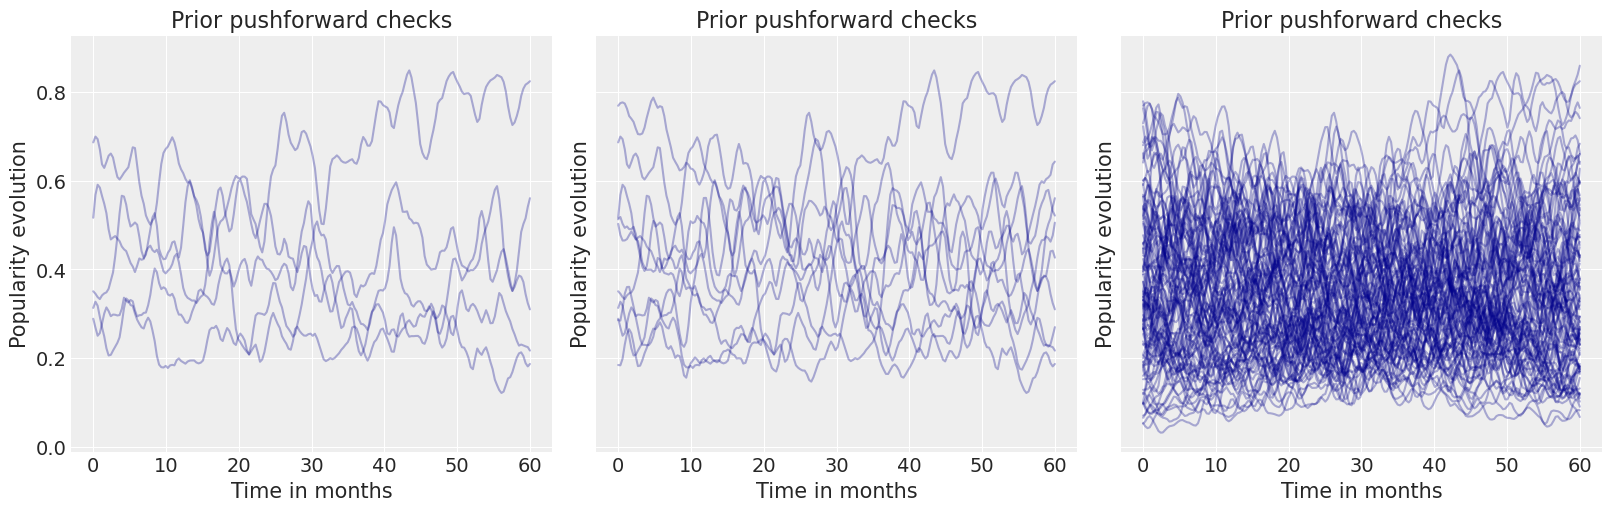

In [16]:
# hide_input
_, (left, mid, right) = plt.subplots(
    1, 3, figsize=(16, 5), constrained_layout=True, sharex=True, sharey=True
)
for ax, samples in zip((left, mid, right), (5, 10, 100)):
    ax.plot(prior_timepoints, prior_approval[:samples].T, color="darkblue", alpha=0.3)
    ax.set_title("Prior pushforward checks")
    ax.set_xlabel("Time in months")
    ax.set_ylabel("Popularity evolution");

Again, each line is a possible path for any president's approval, but this time it's not only the residual variation captured by the GP -- it's the total popularity of the president and its evolution with time. You can see that there are a lot of different paths -- a bit too many to my taste, if I'm being honest. But this will be the case as long as we need a very flexible kernel to accomodate the boundary effects due to changes of presidents. It's ok for now, but if the model has troubles sampling or if we want to improve it, that's definitely one of the first things I'd look at.

Now let's have a look at the marginal quantiles plot (aka ribbon plot):

/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.8/site-packages/arviz/stats/stats.py:484: FutureWarning: hdi currently interp

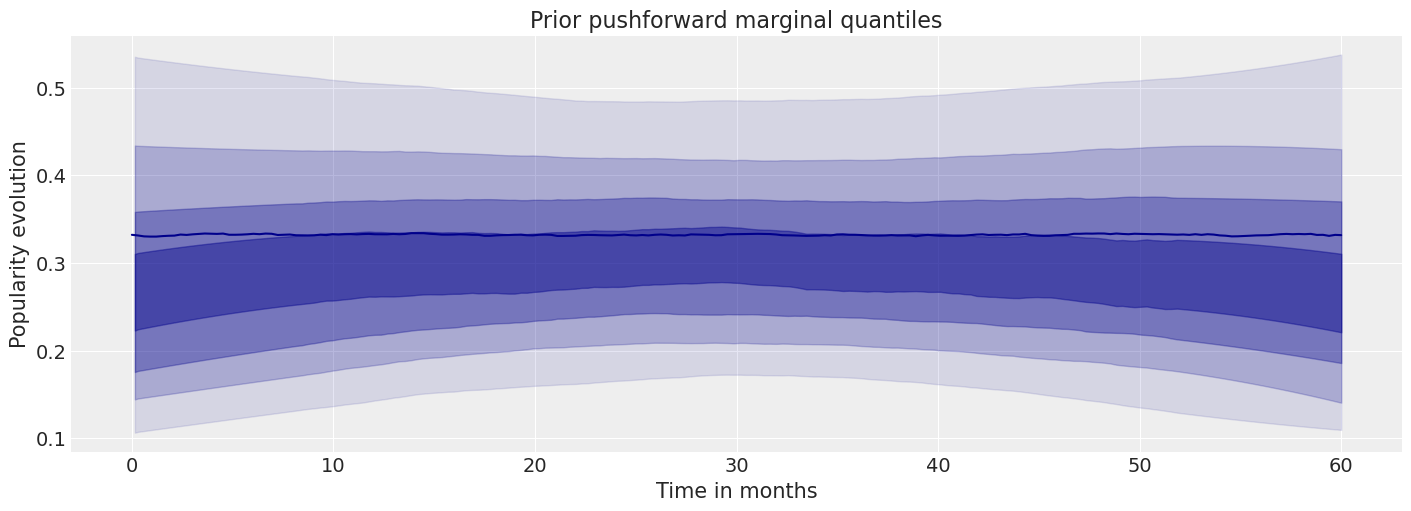

In [17]:
# hide_input
_, ax = plt.subplots(1, 1, figsize=(14, 5))

ax.plot(prior_timepoints.flatten(), np.median(prior_approval, axis=0), color="darkblue")
az.plot_hdi(
    prior_timepoints.flatten(),
    prior_approval,
    hdi_prob=0.2,
    ax=ax,
    color="darkblue",
    fill_kwargs={"alpha": 0.4},
)
az.plot_hdi(
    prior_timepoints.flatten(),
    prior_approval,
    hdi_prob=0.4,
    ax=ax,
    color="darkblue",
    fill_kwargs={"alpha": 0.3},
)
az.plot_hdi(
    prior_timepoints.flatten(),
    prior_approval,
    hdi_prob=0.6,
    ax=ax,
    color="darkblue",
    fill_kwargs={"alpha": 0.2},
)
az.plot_hdi(
    prior_timepoints.flatten(),
    prior_approval,
    hdi_prob=0.8,
    ax=ax,
    color="darkblue",
    fill_kwargs={"alpha": 0.1},
)

ax.set_title("Prior pushforward marginal quantiles")
ax.set_xlabel("Time in months")
ax.set_ylabel("Popularity evolution");

This looks good, although it underestimates the total variation again. The tilt downwards at the boundaries is probably due to a combination of the distortion effect of the logistic link function, the rarity of data at the boundaries (which forces the model to revert to our baseline), and our baseline prior putting lots of probability mass below the baseline. And this is what we want actually: presidents spend more time around or below the baseline than above. The improvement we could make though is to tell the model that popularity should trend downwards for each term (i.e higher at the beginning than at the end). Again, we'd probably need a periodic kernel for that.

## Coding up the model -- Show time!

We now have everything to set up our model in PyMC3! As you'll see, it matches up the latex formulation we saw earlier quite well. There are just two novelties, to make our lives easier: we're using the `coords` and `dims` arguments instead of `shape`; that way, we'll get to select the data returned by our model [with names instead of raw dimensions](https://oriolabril.github.io/oriol_unraveled/python/arviz/pymc3/xarray/2020/09/22/pymc3-arviz.html). Second, we're using the [`pm.Data` container](https://docs.pymc.io/notebooks/data_container.html), to make the model aware of the data we passed; this will make posterior predictions easier down the line.

In [9]:
COORDS = {"timesteps": d.index}

with pm.Model(coords=COORDS) as econ_latent_gp:
    # intercept on logit scale
    baseline = pm.Normal("baseline", -0.7, 0.5)

    # honeymoon slope
    honeymoon = pm.Normal("honeymoon", -0.5, 0.3)

    # log unemployment slope
    log_unemp_effect = pm.Normal("log_unemp_effect", 0.0, 0.2)

    # long term trend
    amplitude_trend = pm.HalfNormal("amplitude_trend", 1.0)
    ls_trend = pm.Gamma("ls_trend", alpha=5, beta=2)
    cov_trend = amplitude_trend ** 2 * pm.gp.cov.Matern52(1, ls_trend)

    # instantiate gp
    gp = pm.gp.Latent(cov_func=cov_trend)
    # evaluate GP at time points
    f_time = gp.prior("f_time", X=time[:, None])

    # data
    election_flag = pm.Data("election_flag", d.election_flag.values, dims="timesteps")
    stdz_log_unemployment = pm.Data(
        "stdz_log_unemployment",
        standardize(np.log(d.unemployment)).values,
        dims="timesteps",
    )
    # unemployment data is uncertain
    # sd = 0.1 says uncertainty on point expected btw 20% of data std 95% of time
    u_diff = pm.Normal("u_diff", mu=0.0, sigma=0.1, dims="timesteps")
    u_uncert = stdz_log_unemployment + u_diff

    # overdispersion parameter
    theta = pm.Exponential("theta_offset", 1.0) + 10.0

    p = pm.Deterministic(
        "p",
        pm.math.invlogit(
            baseline + f_time + honeymoon * election_flag + log_unemp_effect * u_uncert
        ),
        dims="timesteps",
    )

    y = pm.BetaBinomial(
        "y",
        alpha=p * theta,
        beta=(1.0 - p) * theta,
        n=d.N_total,
        observed=d.N_approve,
        dims="timesteps",
    )

And now is the time to _actually_ run our model 🥳 We'll run 8 chains and draw 2000 samples in each of them. This is good practice because 1) each chain is quite long, so it should be able to eventually explore problematic regions if there are any, and 2) each chain starts its exploration at a different point in space, increasing our chances to explore _all_ the typical set.

In [10]:
with econ_latent_gp:
    trace_econ = pm.sample(
        draws=2000,
        chains=8,
        cores=8,
        return_inferencedata=True,
        idata_kwargs={
            "dims": {"f_time": ["timesteps"], "f_time_rotated_": ["timesteps"]}
        },
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [theta_offset, u_diff, f_time_rotated_, ls_trend, amplitude_trend, log_unemp_effect, honeymoon, baseline]


Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 1164 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


## Diagnosing the model -- What's wrong with you??

This is looking good! No warnings, no divergences and a really decent sampling time: 24,000 samples in 20 min (including tuning, which takes always longer), i.e 20 draws per second -- for a GP, this is really good!

So, we have no red flags here. This doesn't mean our model is good yet, but it increases the chances that it is. Let's look at the trace plot now, to make sure sampling did go well:

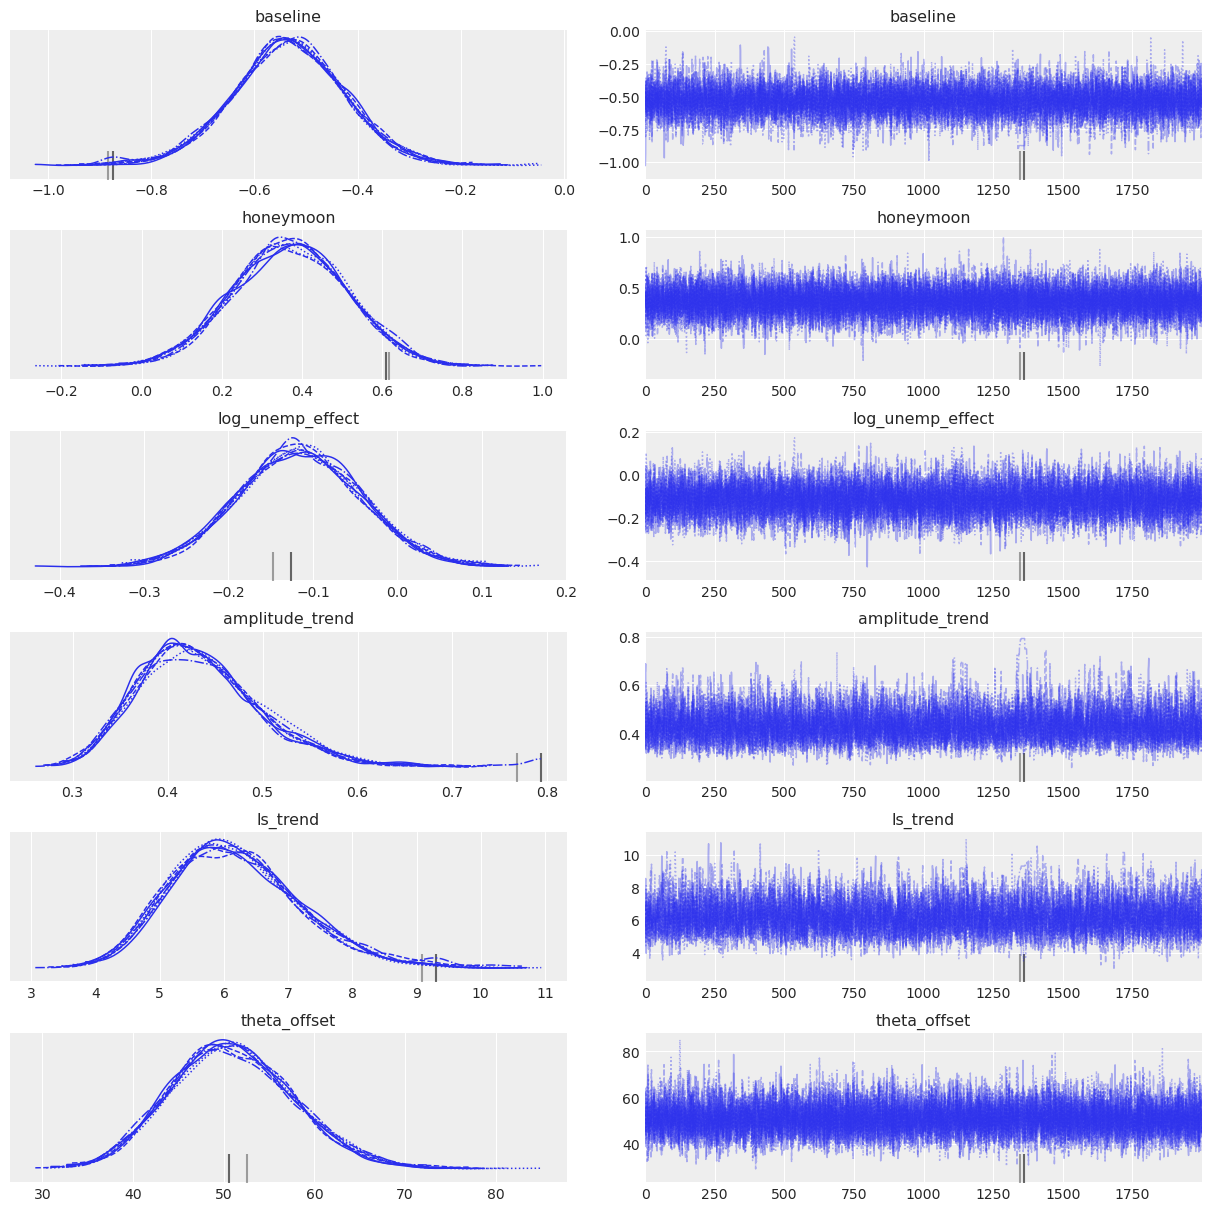

In [11]:
az.plot_trace(
    trace_econ, compact=True, var_names=["~u_diff", "~p", "~f_time", "~f_time_rotated_"]
);

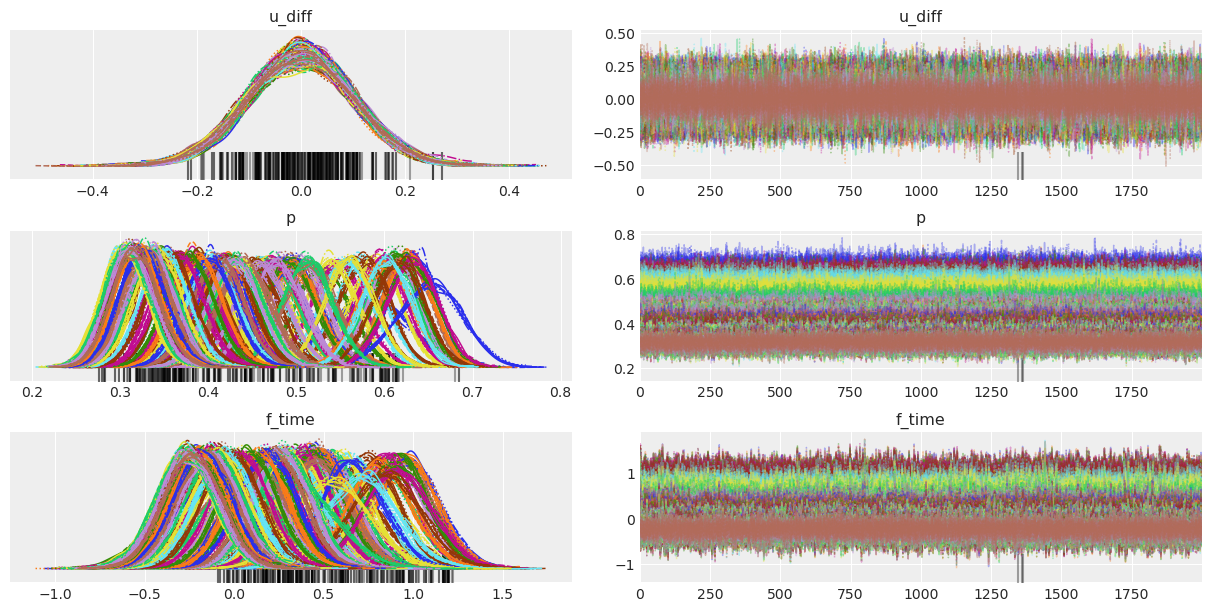

In [12]:
az.plot_trace(
    trace_econ,
    var_names=["u_diff", "p", "f_time"],
    compact=True,
    coords={"timesteps": trace_econ.observed_data.timesteps[:110]},
);

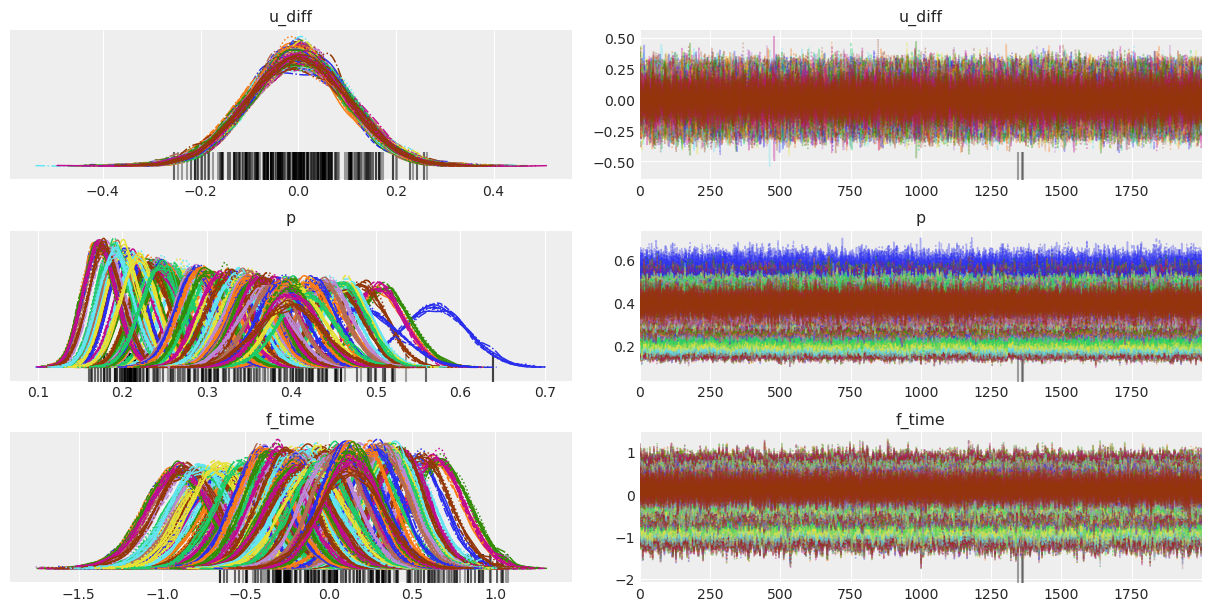

In [13]:
# hide
az.plot_trace(
    trace_econ,
    var_names=["u_diff", "p", "f_time"],
    compact=True,
    coords={"timesteps": trace_econ.observed_data.timesteps[110:]},
);

Well indeed, that looks good! The chains are mixing well for all parameters, as indicated by the KDEs (leftmost plot), and they show a random walk behavior, as evidenced by the "caterpillars" on the rightmost plot.

> Tip: Want more details about trace plots? [This blog post](https://oriolabril.github.io/oriol_unraveled/python/arviz/matplotlib/2020/06/20/plot-trace.html) is really good 👌

Now let's look at the pair plot, to see if our posterior distributions exhibit high correlations or, worse, nasty funnel degeneracies 😱

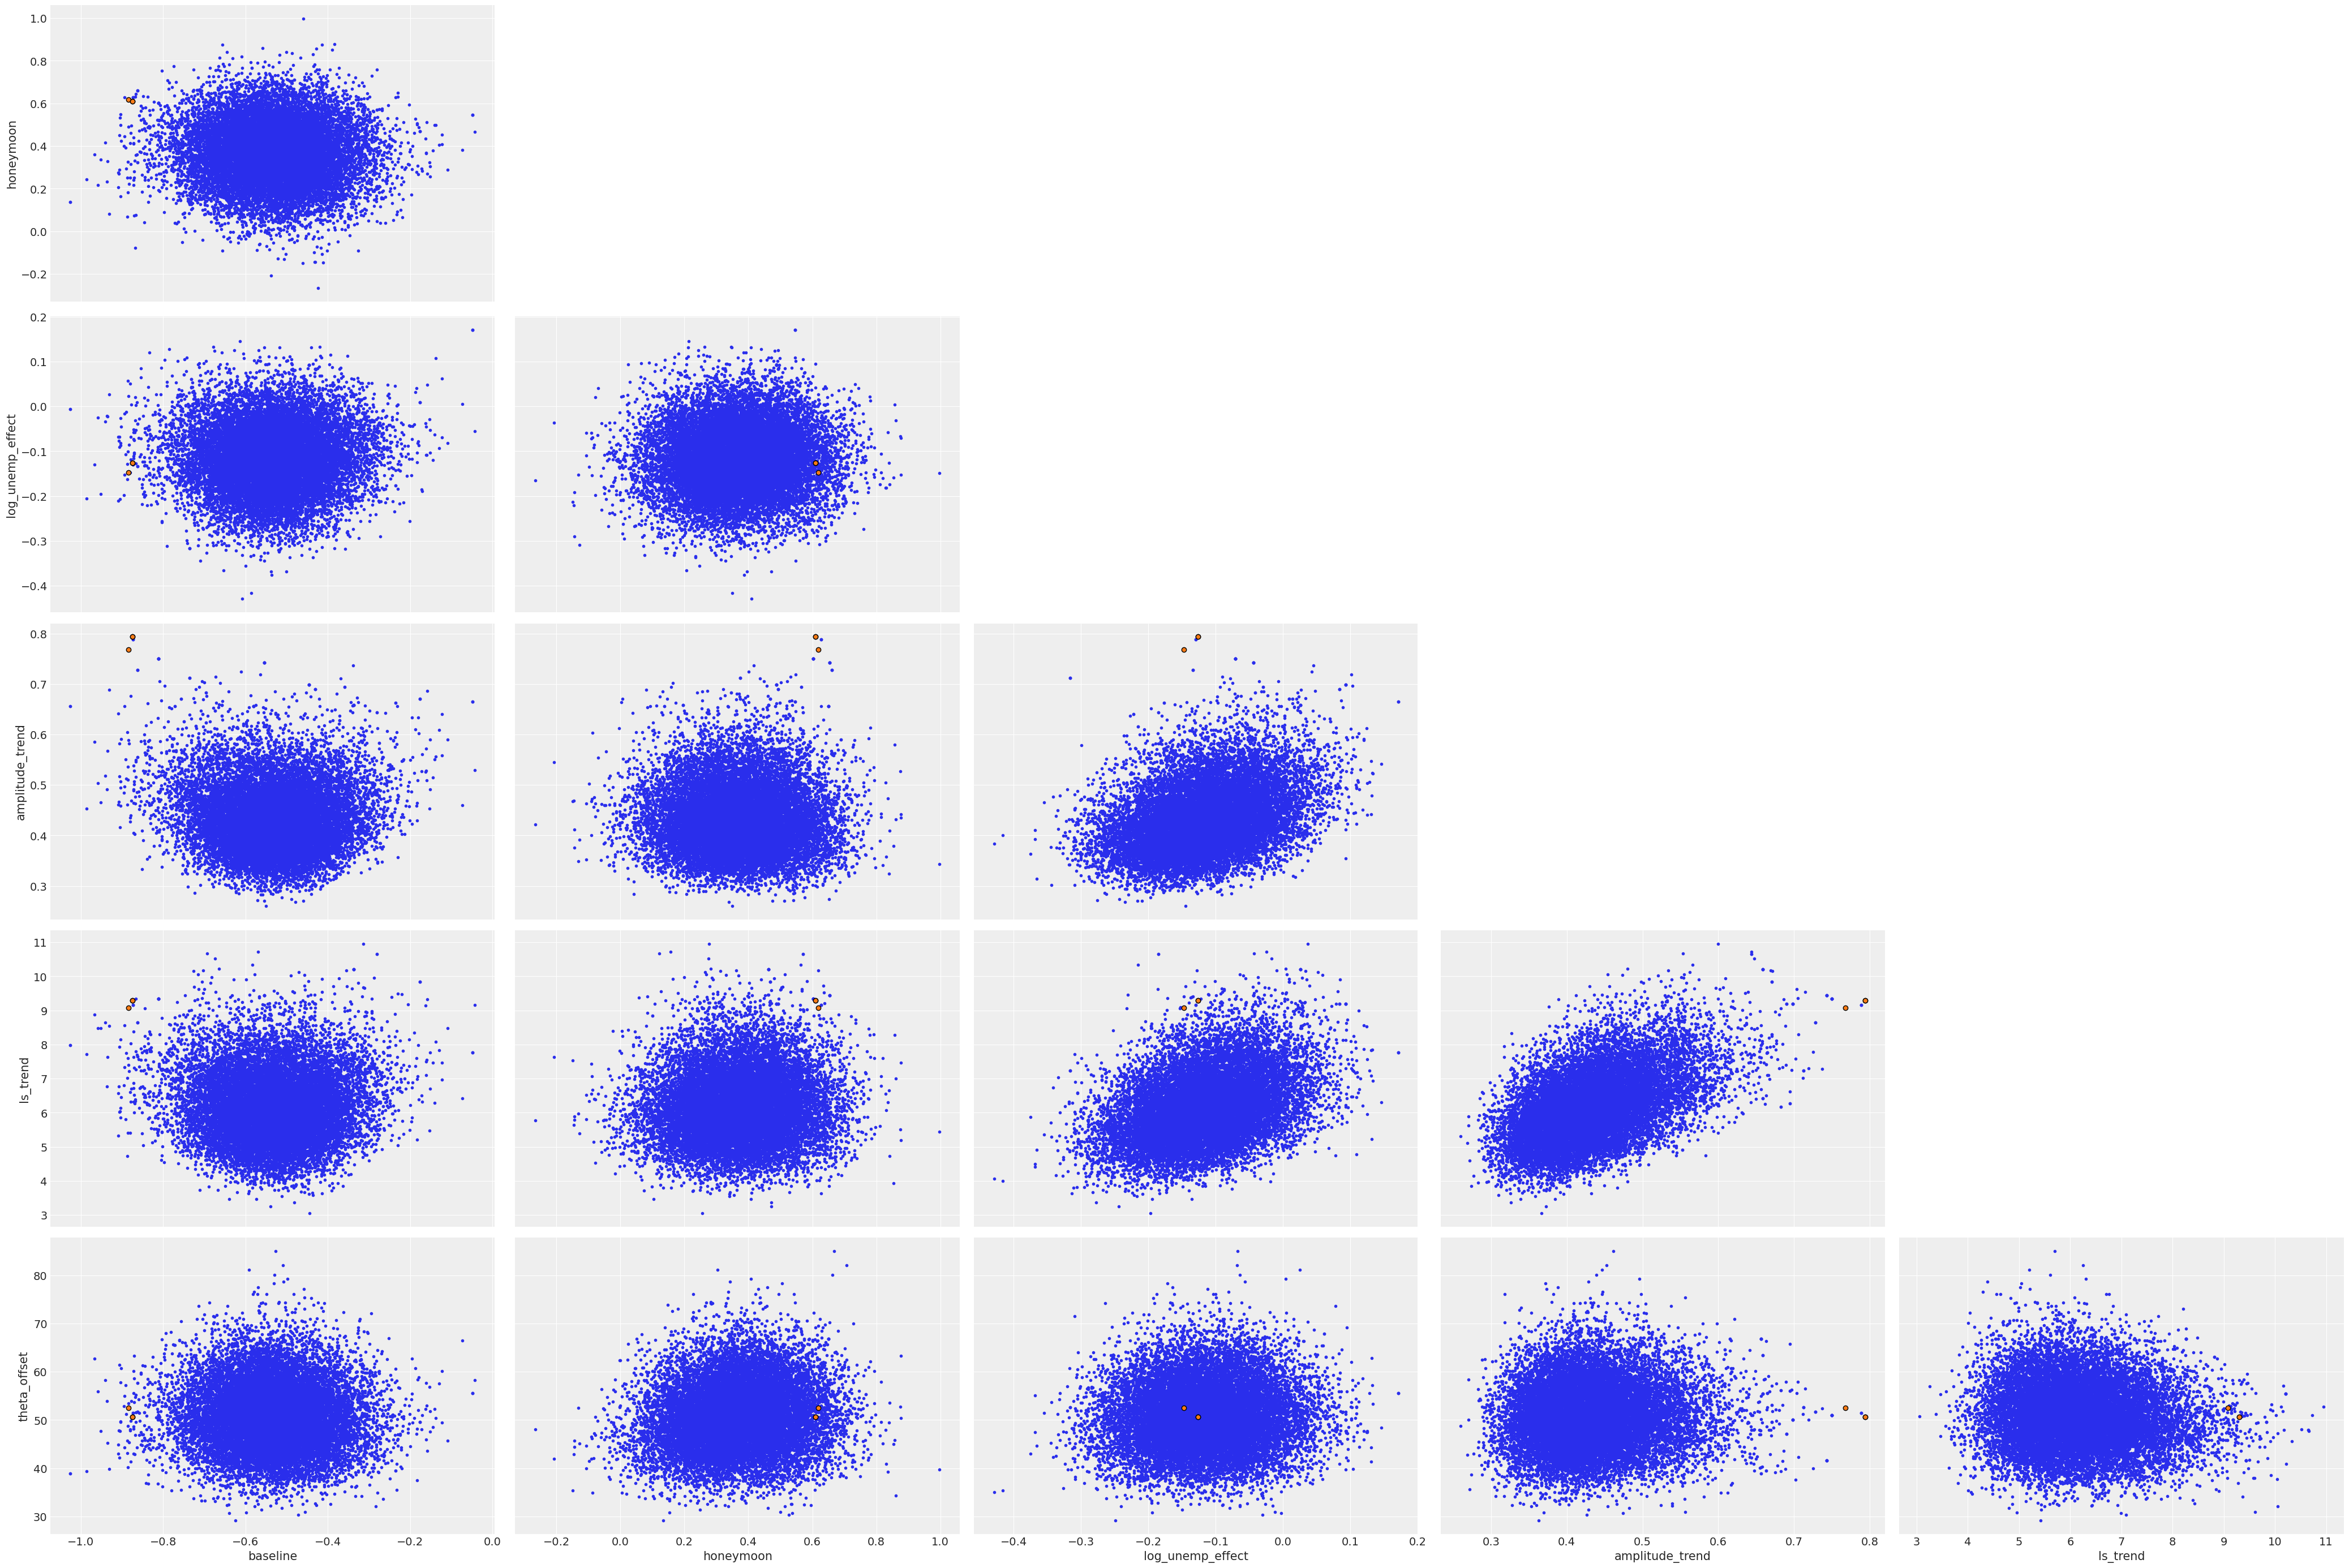

In [14]:
az.plot_pair(
    trace_econ,
    var_names=["~u_diff", "~p", "~f_time", "~f_time_rotated_"],
    divergences=True,
);

Again, this is all looking good! Almost all plots look like fuzzy balls (so, don't show this plot to your cat!), hinting that there are no particular posterior correlations between our parameters. We see though that there could be a problem for high values of `amplitude_trend` and `ls_trend` (the two parameters of our GP kernel), for a reason that we would have to investigate. But since we've thought hard about those priors beforehand and happened to choose distributions skeptical of high values, it seems that we were able to prevent those degeneracies from happening -- _Minority Report_ style 🤙

Everything seems to be going well here, but just for fun, let's use one of [ArviZ](https://arviz-devs.github.io/arviz/)'s latest features and display the rank plot!

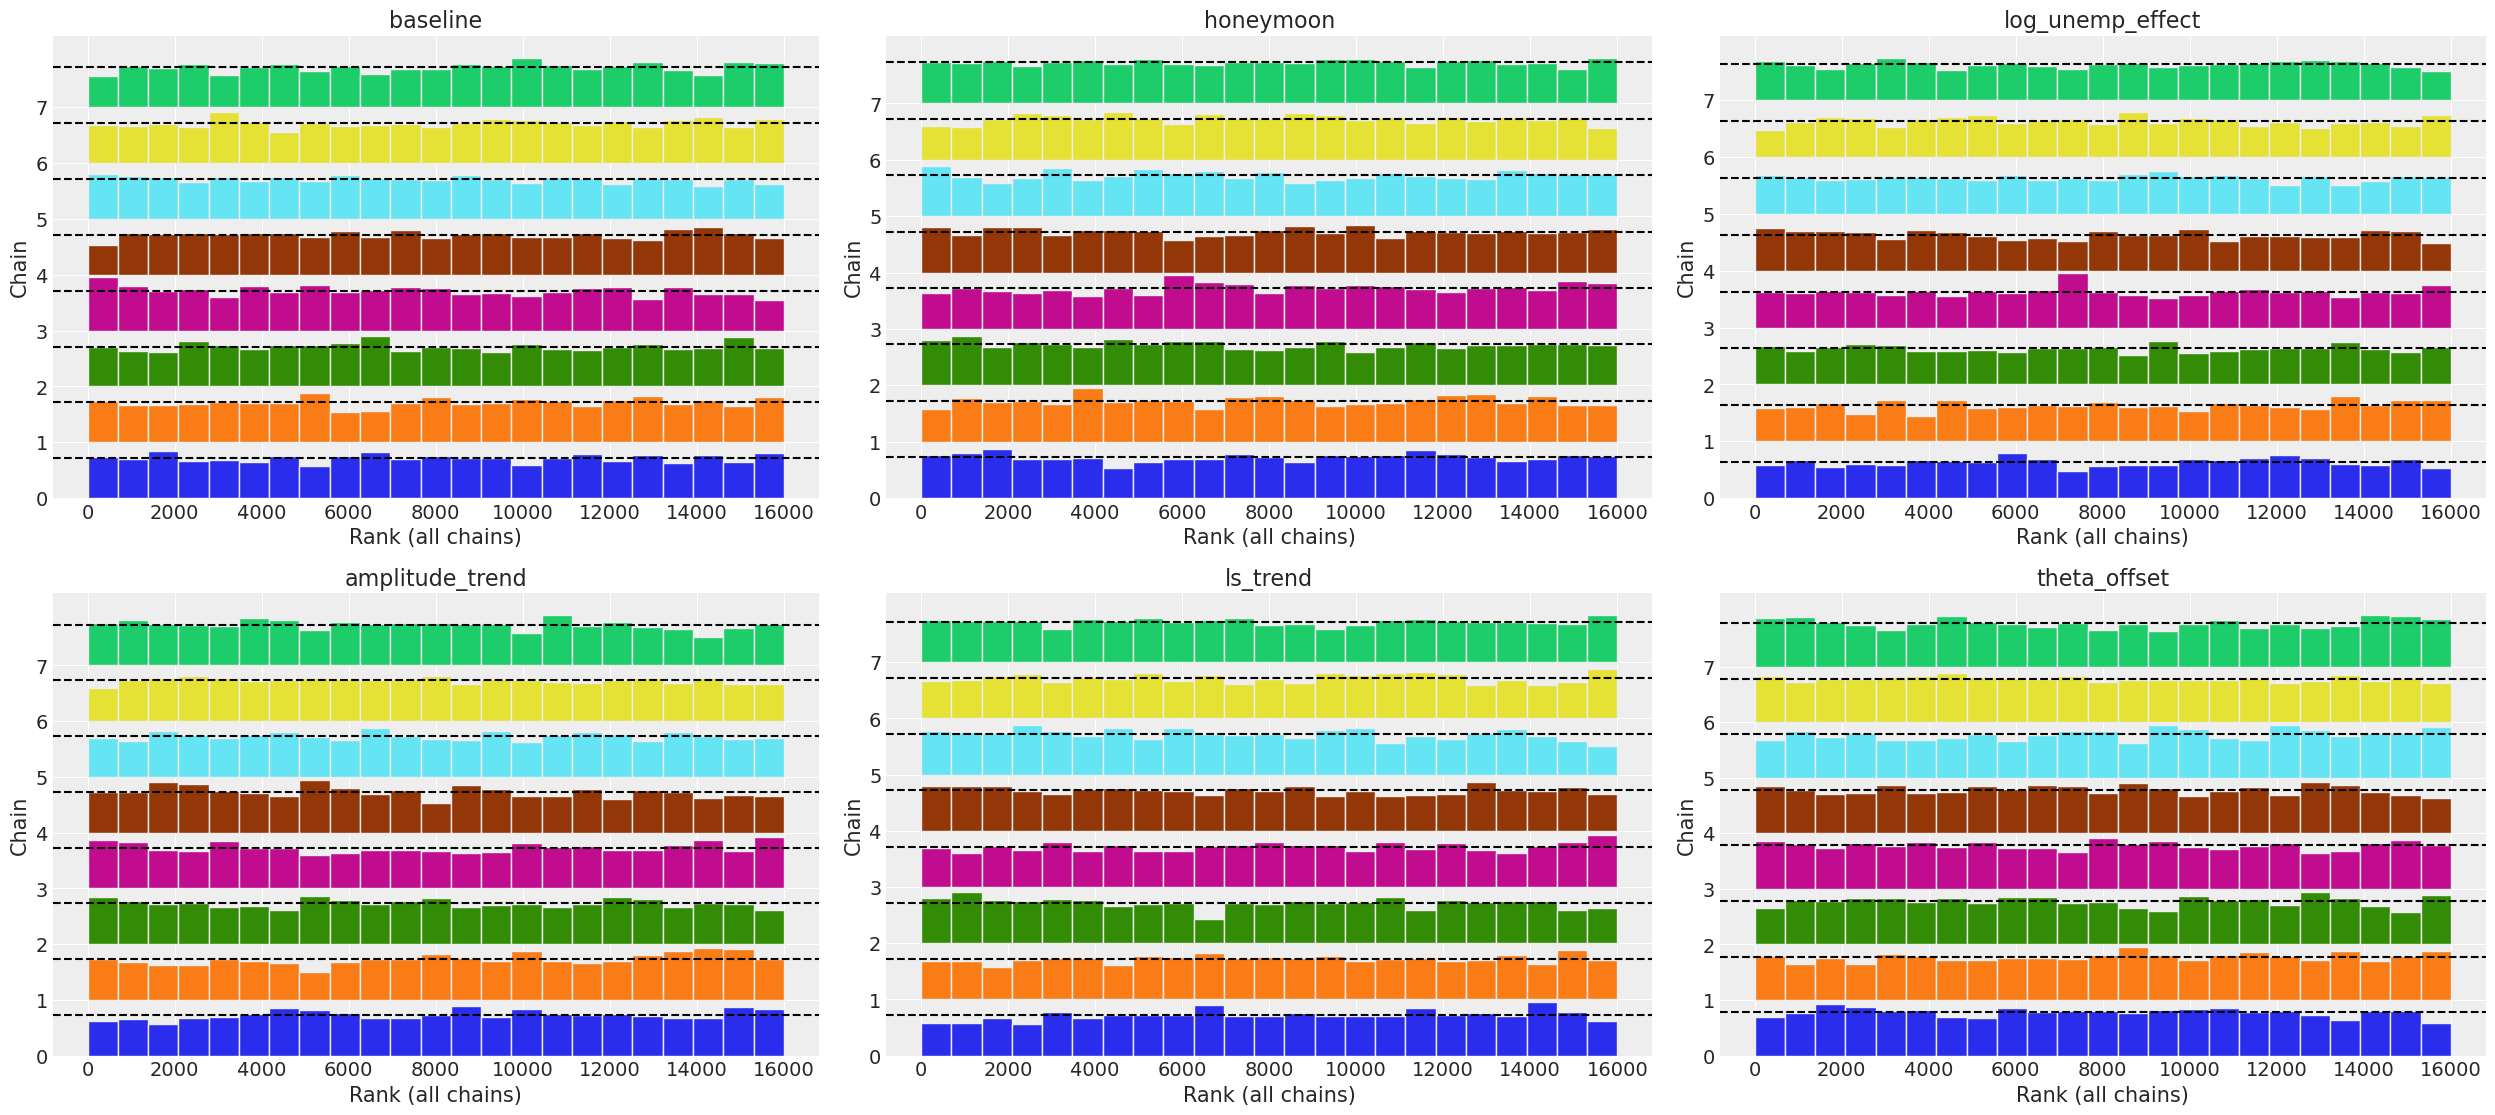

In [15]:
az.plot_rank(trace_econ, var_names=["~u_diff", "~p", "~f_time", "~f_time_rotated_"]);

"That looks cool Alex... but how do I read that?" 🤔 Well, as stated in the [original paper](https://arxiv.org/abs/1903.08008):

> Rank plots are histograms of the ranked posterior draws (ranked over all chains) plotted separately for each chain. If all of the chains are targeting the same posterior, we expect the ranks in each chain to be uniform, whereas if one chain has a different location or scale parameter, this will be reflected in the deviation from uniformity. If rank plots of all chains look similar, this indicates good mixing of the chains.

And here, our rank plots look pretty uniform, so, again, we're all good! By the way, if you want an example of rank plots indicating problems, look at the examples on [this page](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_rank.html) 😉

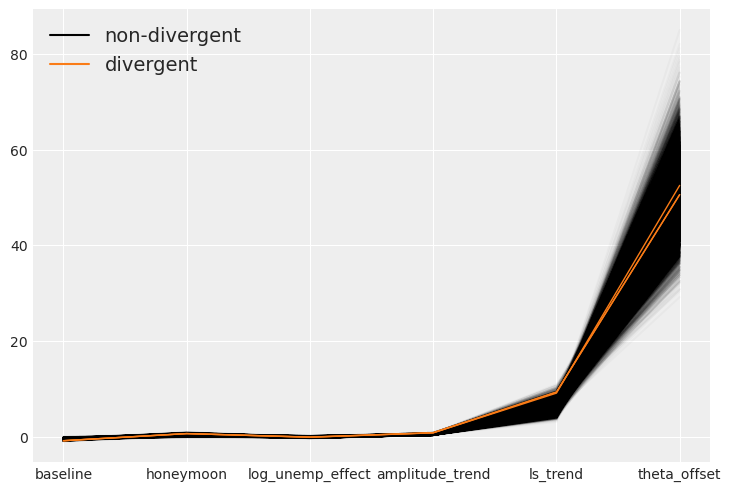

In [16]:
# hide
az.plot_parallel(trace_econ, var_names=["~u_diff", "~p", "~f_time", "~f_time_rotated_"]);

## Predicting popularity -- I see the future!

Plots and diagnostics are good to show us if there was a computational issue in our model, but they don't tell us if our model is good at predicting whatever it's supposed to predict. That part is always very specific to the model and use-case at hand, so there is no universal method. We could look at the summary table of our coefficients' posterior:

In [17]:
az.summary(
    trace_econ, var_names=["~u_diff", "~p", "~f_time", "~f_time_rotated_"], round_to=2
)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
baseline          -0.53  0.11   -0.74    -0.33       0.00     0.00  10390.00   
honeymoon          0.37  0.14    0.12     0.64       0.00     0.00  21678.81   
log_unemp_effect  -0.12  0.07   -0.25     0.02       0.00     0.00  11776.94   
amplitude_trend    0.44  0.07    0.32     0.56       0.00     0.00   3772.14   
ls_trend           6.19  1.02    4.43     8.17       0.01     0.01   4879.90   
theta_offset      50.99  6.78   38.52    63.80       0.05     0.04  15387.76   

                    ess_sd  ess_bulk  ess_tail  r_hat  
baseline           8463.91  11531.45   5747.96    1.0  
honeymoon         19646.43  21719.32   8101.78    1.0  
log_unemp_effect  11776.94  11846.54  10213.51    1.0  
amplitude_trend    2925.72   5417.12   3950.73    1.0  
ls_trend           4538.86   5279.26   4650.60    1.0  
theta_offset      14757.36  15658.94  10423.08    1.0

But then you'd say: "uh, yeah... what does that mean? What's the relationship with popularity?". And you'd be right: apart from giving us an idea of the direction and magnitude of the covariance between each parameter (all the other held constant) and the president's popularity, a simple summary table doesn't convey much.

We can use it as a "gut check" though: the mean baseline popularity across time is $logistic(-0.54) = 0.37$. The honeymoon effect is indeed inferred to be positive, while an increase in unemployment is associated with a slight decrease in popularity. All these inferences are consistent with our domain knowledge -- no 🚩

The best way to make sense of all this though is to predict on new data (i.e "out-of-sample") and visualize these predictions. So let's predict three months out-of-sample! For this, we need the time data:

In [18]:
MAX_OBSERVED = len(d.index)
OOS_MONTHS = 3  # 1 quarter out-of-sample
MAX_TIME = MAX_OBSERVED + OOS_MONTHS

tnew = np.linspace(0, MAX_TIME, MAX_TIME)[:, None]

There is no presidential election on the forecasted horizon, so our new `election_flag` vector is all 0, which means it disappears from our regression. However, we need new unemployment data for the next three months -- and that's a bit more fun, because we get to be creative!

What are reasonable values? There are plenty of paths we could try. Conveniently, we're only forecasting one quarter, so we only need one data point for unemployment -- and then we'll add the random noise we inferred with our model (`u_diff`), so in reality we'll get 3 values that are close to each other.

The path we'll take here is very simple: let's assume that unemployment stays around its last value, with some noise equal to the standard deviation we observed in the sample. Let's write a small function to do all these steps easily and robustly:

In [19]:
log_unemp = np.log(d.unemployment)


def generate_oos_unemp_data(center: float, oos_months: int) -> np.ndarray:
    """
    Generate out-of-sample unemployment data around `center` and for `oos_months`.
    """
    # unemployment is around `center`
    ppc_unemp = np.random.normal(
        loc=center,
        scale=d.unemployment.std(),
        size=oos_months // 3,
    )
    # data only observed quarterly, so need to forward-fill
    ppc_unemp = np.repeat(ppc_unemp, repeats=3)

    # log data and scale
    stdz_log_ppc_unemp = (np.log(ppc_unemp) - log_unemp.mean()) / log_unemp.std()

    # add noise around values
    return stdz_log_ppc_unemp + np.random.normal(
        loc=trace_econ.posterior["u_diff"].mean(),
        scale=trace_econ.posterior["u_diff"].std(),
        size=OOS_MONTHS,
    )

In [20]:
# unemployment stays around last value
oos_unemp = generate_oos_unemp_data(
    center=d.unemployment.iloc[-1], oos_months=OOS_MONTHS
)
oos_unemp

array([-1.25930985, -0.9589194 , -1.33139905])

Great, now let's generate predictions, shall we? This is pretty simple, we just have to give to PyMC3 our new $unemp\_ data$, $election\_ flag$ and time data. Then it will automatically sample 1,000 possible paths that the president's popularity could take in the coming 3 months, depending on the future values of unemployment. In other words, we will get 1,000 different timeseries that are all compatible with our prior knowledge and the data we got to observe -- Bayesian inference baby 😎

In [21]:
PREDICTION_COORDS = {
    "timesteps": pd.date_range(
        start=COORDS["timesteps"][0],
        end=COORDS["timesteps"][-1] + pd.DateOffset(months=OOS_MONTHS),
        freq="M",
    )
}

with econ_latent_gp:
    pm.set_data(
        {
            "election_flag": np.concatenate(
                (
                    d.election_flag.values,
                    np.zeros(OOS_MONTHS, dtype=int),
                )
            ),
            "stdz_log_unemployment": np.concatenate(
                (standardize(log_unemp).values, oos_unemp)
            ),
        }
    )
    f_time_new = gp.conditional("f_time_new", Xnew=tnew)

    ppc = pm.sample_posterior_predictive(
        trace_econ.posterior,
        samples=1000,
        var_names=["baseline", "f_time_new", "honeymoon", "log_unemp_effect"],
    )

    az.from_pymc3_predictions(
        ppc,
        idata_orig=trace_econ,
        inplace=True,
        coords=PREDICTION_COORDS,
        dims={"f_time_new": ["timesteps"]},
    )

/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.8/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [22]:
# hide
az.to_netcdf(trace_econ, "../../pollsposition_models/popularity/trace_raw_econ.nc")

'../../pollsposition_models/popularity/trace_raw_econ.nc'

In [10]:
# hide
trace_econ = az.from_netcdf("../../pollsposition_models/popularity/trace_raw_econ.nc")

And now we just plug these posterior predictive samples into our regression formula, to get back the predictive share of people who will approve of the president's job in the coming 3 months:

In [23]:
def compute_post_pred_approval(
    unemp_oos: xr.DataArray = trace_econ.predictions_constant_data[
        "stdz_log_unemployment"
    ],
) -> xr.DataArray:
    """
    Compute job approval from posterior predictive samples.

    unemp_oos: out-of-sample values for unemployment.
    Defaults to the values stored in the `InferenceData.predictions_constant_data`
    group, i.e unemployment stays around last value.
    """
    return logistic(
        trace_econ.predictions["baseline"]
        + trace_econ.predictions["f_time_new"]
        + trace_econ.predictions["honeymoon"]
        * trace_econ.predictions_constant_data["election_flag"]
        + trace_econ.predictions["log_unemp_effect"] * unemp_oos
    )

In [24]:
pp_prop = compute_post_pred_approval()

Great, we have computed posterior predictions and now have everything we need to plot them and see if they make sense. But first, what we can do for fun is use the same method as above to simulate posterior predictions for the cases when unemployment jumps to 10% or drops to 5% in the following quarter, instead of staying more or less the same.

Of course, this is not very realistic, as unemployment rarely changes that drastically, but this is to show-case how easy it is to generate counterfactuals in the Bayesian framework. It'll also allow us to further evaluate our model: if the different scenarios and their relative differences are consistent with our domain knowledge, this is another good point for our model.

In [25]:
# unemployment drops to 5%
oos_unemp_5 = generate_oos_unemp_data(center=5.0, oos_months=OOS_MONTHS)

pp_prop_5 = compute_post_pred_approval(
    unemp_oos=xr.DataArray(
        np.concatenate((standardize(log_unemp).values, oos_unemp_5)),
        dims=["timesteps"],
        coords=PREDICTION_COORDS,
    )
)

# unemployment jumps to 10%
oos_unemp_10 = generate_oos_unemp_data(center=10.0, oos_months=OOS_MONTHS)

pp_prop_10 = compute_post_pred_approval(
    unemp_oos=xr.DataArray(
        np.concatenate((standardize(log_unemp).values, oos_unemp_10)),
        dims=["timesteps"],
        coords=PREDICTION_COORDS,
    )
)

Ok, I can sense the suspense is at its peak now, so let's finally plot these predictions! The code is quite long, so I hid it by default, but the curious among you can expand it if they so wish.

In [26]:
# hide
raw_polls = all_presidents.loc[all_presidents.index >= pd.to_datetime("2002-05-05")]

# convert to proportions
raw_polls[["approve_pr", "disapprove_pr"]] = (
    raw_polls[["approve_pr", "disapprove_pr"]].copy() / 100
)
raw_polls = raw_polls.rename(
    columns={"approve_pr": "p_approve", "disapprove_pr": "p_disapprove"}
)
raw_polls

/Users/alex_andorra/opt/anaconda3/envs/elections-models/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


president sondage  samplesize        method  p_approve  \
2002-05-15   chirac2    Ifop         924         phone       0.51   
2002-05-20   chirac2  Kantar         972  face to face       0.50   
2002-05-23   chirac2     BVA        1054         phone       0.52   
2002-05-26   chirac2   Ipsos         907         phone       0.48   
2002-06-16   chirac2    Ifop         974         phone       0.49   
...              ...     ...         ...           ...        ...   
2020-12-23    macron  Harris        1000      internet       0.49   
2021-01-06    macron   Elabe        1001      internet       0.35   
2021-01-06    macron  Yougov        1061      internet       0.32   
2021-01-08    macron    Ifop        1028      internet       0.45   
2021-01-14    macron   Odoxa        1003      internet       0.40   

            p_disapprove  
2002-05-15          0.44  
2002-05-20          0.48  
2002-05-23          0.37  
2002-05-26          0.48  
2002-06-16          0.43  
...                  ...  
2020-12-23          0.51  
2021-01-06          0.61  
2021-01-06          0.61  
2021-01-08          0.55  
2021-01-14          0.60  

[1049 rows x 6 columns]

In [28]:
# hide
# save data for Bokeh plot
pp_prop.to_dataset(name="post_pred_approval").to_netcdf(
    "../../pollsposition_models/popularity/plot_data/post_pred_approval.nc"
)
pp_prop_5.to_dataset(name="post_pred_approval_5").to_netcdf(
    "../../pollsposition_models/popularity/plot_data/post_pred_approval_5.nc"
)
pp_prop_10.to_dataset(name="post_pred_approval_10").to_netcdf(
    "../../pollsposition_models/popularity/plot_data/post_pred_approval_10.nc"
)
raw_polls.to_csv("../../pollsposition_models/popularity/plot_data/raw_polls.csv")
pd.DataFrame.from_dict(PREDICTION_COORDS).to_csv("../../pollsposition_models/popularity/plot_data/prediction_coords.csv")

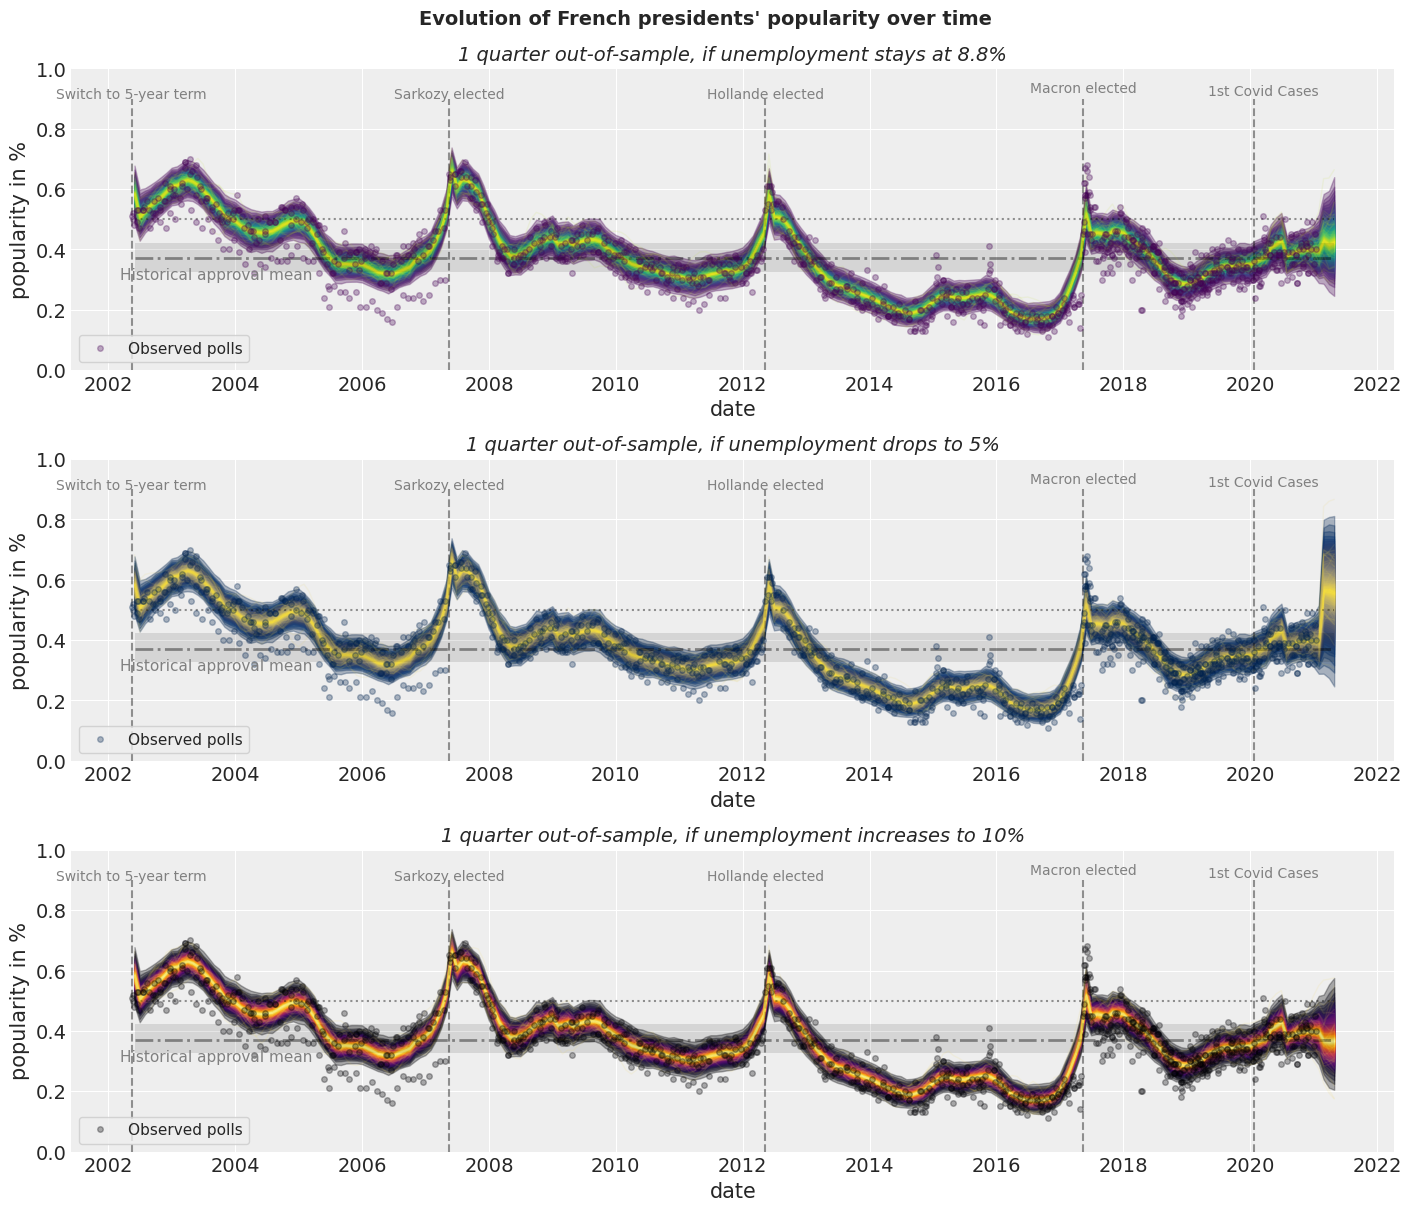

In [29]:
# collapse
_, (top, mid, low) = plt.subplots(
    3, 1, figsize=(14, 12), constrained_layout=True, sharey=True
)

pp_dates = pd.date_range(
    start=d.index[0] - np.timedelta64(0, "M"),
    periods=MAX_TIME,
    freq="M",
).values

# plot the samples from the gp posterior with samples and shading
pm.gp.util.plot_gp_dist(
    top,
    pp_prop.stack(sample=("chain", "draw")).data.T,
    pp_dates,
    plot_samples=True,
    palette="viridis",
    fill_alpha=0.3,
)
pm.gp.util.plot_gp_dist(
    mid,
    pp_prop_5.stack(sample=("chain", "draw")).data.T,
    pp_dates,
    plot_samples=True,
    palette="cividis",
    fill_alpha=0.3,
)
pm.gp.util.plot_gp_dist(
    low,
    pp_prop_10.stack(sample=("chain", "draw")).data.T,
    pp_dates,
    plot_samples=True,
    palette="inferno",
    fill_alpha=0.3,
)

for ax, cmap, title in zip(
    (top, mid, low),
    (plt.cm.viridis(0), plt.cm.cividis(0), plt.cm.inferno(0)),
    (f"stays at {d.unemployment.iloc[-1]}%", "drops to 5%", "increases to 10%"),
):
    # plot data
    ax.plot(
        raw_polls.index,
        raw_polls.p_approve.values,
        "o",
        ms=4,
        color=cmap,
        alpha=0.3,
        label="Observed polls",
    )

    # plot historical baseline
    ax.hlines(
        logistic(trace_econ.predictions["baseline"].mean()),
        pp_dates[0],
        pp_dates[-1],
        "k",
        "-.",
        alpha=0.4,
        lw=2,
    )
    ax.fill_between(
        pp_dates,
        logistic(az.hdi(trace_econ.predictions)["baseline"]).sel(hdi="lower"),
        logistic(az.hdi(trace_econ.predictions)["baseline"]).sel(hdi="higher"),
        color="k",
        edgecolor="none",
        alpha=0.1,
    )
    ax.text(
        pd.to_datetime("2003-09-14"),
        0.3,
        "Historical approval mean",
        fontsize=11,
        color="grey",
        horizontalalignment="center",
    )

    # annotate graph
    ax.hlines(
        0.5,
        pp_dates[0],
        pp_dates[-1],
        "k",
        ":",
        alpha=0.4,
    )

    ax.vlines(pd.to_datetime("2002-05-14"), 0.0, 0.9, "k", "--", alpha=0.4)
    ax.text(
        pd.to_datetime("2002-05-14"),
        0.9,
        "Switch to 5-year term",
        fontsize=10,
        color="grey",
        horizontalalignment="center",
    )

    ax.vlines(pd.to_datetime("2007-05-16"), 0.0, 0.9, "k", "--", alpha=0.4)
    ax.text(
        pd.to_datetime("2007-05-16"),
        0.9,
        "Sarkozy elected",
        fontsize=10,
        color="grey",
        horizontalalignment="center",
    )

    ax.vlines(pd.to_datetime("2012-05-11"), 0.0, 0.9, "k", "--", alpha=0.4)
    ax.text(
        pd.to_datetime("2012-05-11"),
        0.9,
        "Hollande elected",
        fontsize=10,
        color="grey",
        horizontalalignment="center",
    )

    ax.vlines(pd.to_datetime("2017-05-17"), 0.0, 0.9, "k", "--", alpha=0.4)
    ax.text(
        pd.to_datetime("2017-05-17"),
        0.92,
        "Macron elected",
        fontsize=10,
        color="grey",
        horizontalalignment="center",
    )

    ax.vlines(pd.to_datetime("2020-01-24"), 0.0, 0.9, "k", "--", alpha=0.4)
    ax.text(
        pd.to_datetime("2020-03-17"),
        0.91,
        "1st Covid Cases",
        fontsize=10,
        color="grey",
        horizontalalignment="center",
    )

    # axis labels and title
    ax.set_ylim((0, 1))
    ax.set_xlabel("date")
    ax.set_ylabel("popularity in %")
    ax.set_title(
        f"1 quarter out-of-sample, if unemployment {title}",
        fontsize=14,
        fontstyle="italic",
    )
    ax.legend(fontsize=11, loc="lower left", frameon=True)
plt.suptitle(
    "Evolution of French presidents' popularity over time",
    fontsize=14,
    fontweight="bold",
)
plt.savefig("../../pollsposition_models/popularity/gp-popularity")

Well I'd say this is looking pretty good! As advertised, for each of the three counterfactuals, we got a whole distribution of time series -- 1,000 of them to be precise, each time series spanning from 2002 to the current month + one quarter.

This article was a tutorial to show you the model, so, for the lessons we can draw from this plot, let's go to the [interactive version of this plot](#) 😉

---

I hope you enjoyed this tutorial and that now you fancy trying out PyMC3 in your own domain -- if you also learned a thing or two about how French presidents' popularity evolves with time, well that's even better! If you have any questions, suggestions, or spot a mistake somewhere (yeah, I'm a pretty great man but I do make mistakes too -- 1.5 per year on average, to be precise), feel free to comment below or open an issue on the [GitHub repo](https://github.com/AlexAndorra/pollsposition_blog).

For anything else (especially immoderate praise), you can [reach out on Twitter](https://twitter.com/alex_andorra), and if you'd like to learn more about Bayesian inference, feel free to check out my ["Learning Bayesian Statistics" podcast](https://www.learnbayesstats.com/), where I interview practitioners and researchers about why and how they use these methods.

Thanks for reading! Keep calm and PyMCheers 🖖

_PS: I wanted to leave you on a poetic note, so here is a list of the great packages I used to run this analysis_ 😍

In [30]:
# hide_input
%load_ext watermark
%watermark -a AlexAndorra -n -u -v -iv

arviz  0.10.0
xarray 0.16.0
numpy  1.19.1
pymc3  3.9.3
pandas 1.0.5
AlexAndorra 
last updated: Fri Jan 22 2021 

CPython 3.8.5
IPython 7.19.0
